In [7]:
# ========== 基础库 ==========
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")

# 输出目录
OUTDIR = "./_did_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ========== Matplotlib 外观（简洁美观）==========
plt.rcParams.update({
    "figure.figsize": (7.5, 4.2),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.frameon": False,
    "savefig.dpi": 200,
})

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print(f"[saved] {path}")

# ========== 文件名（按实际情况改）==========
panel_path = "ETH_AwashKesem_Panel_Kebele_NDVI_Rain_TreatPost_2018_2024_v01.csv"
covar_path = "ETH_AwashKesem_StaticCovariates_Kebele_SRTM_Slope_v01.csv"
viirs_path = "ETH_AwashKesem_VIIRSmean_byKebele_2018_2024_v01.csv"  # 若没导出可忽略

# ========== 读数 ==========
panel = pd.read_csv(panel_path)
covar = pd.read_csv(covar_path)

# 合并静态协变量（海拔/坡度）
panel = panel.merge(
    covar[["Kebele_ID", "elevation", "slope"]],
    on="Kebele_ID", how="left"
)

# （可选）合并 VIIRS 夜灯
if os.path.exists(viirs_path):
    viirs = pd.read_csv(viirs_path)
    panel = panel.merge(
        viirs[["Kebele_ID", "Year", "VIIRS_mean"]],
        on=["Kebele_ID", "Year"], how="left"
    )

# 统一类型与温和去极值
for c in ["Year","NDVI","RAIN_JJAS","post","treated","treat_share","elevation","slope","area_km2"]:
    if c in panel.columns:
        panel[c] = pd.to_numeric(panel[c], errors="coerce")

# 若未提供 post，则以 2020 为处理断点
if "post" not in panel.columns or panel["post"].isna().all():
    panel["post"] = (panel["Year"] >= 2020).astype(int)

# 对 NDVI/RAIN 做温和 winsorize（1%–99%），避免极端值干扰
for v in ["NDVI","RAIN_JJAS"]:
    if v in panel.columns:
        q1, q99 = panel[v].quantile([0.01, 0.99])
        panel[v] = panel[v].clip(q1, q99)

# 分类变量（用于固定效应）
panel["Kebele_ID"] = panel["Kebele_ID"].astype(str).astype("category")
panel["Year"]      = panel["Year"].astype(int)
panel["Year_cat"]  = panel["Year"].astype("category")

print("rows =", len(panel))
print("years =", sorted(panel['Year'].unique()))
print("kebele =", panel['Kebele_ID'].nunique())
panel.head(3)

rows = 6090
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
kebele = 870


,Kebele_ID,Kebele_Name,W_NAME,Z_NAME,T_NAME,treated,treat_share,area_km2,Year,NDVI,RAIN_JJAS,post,elevation,slope,VIIRS_mean,Year_cat
0,ecba1d05-116b-4e2d-ba3f-5d4c516ba924,Amibara,Amibara,Zone 03,NaN,1,1.000000,15.006547,2018,NaN,227.28129,0,739.699465,1.641476,NaN,2018
1,d37ccaf0-a552-4cfd-a6b8-6f993befac3c,Amibara,Amibara,Zone 03,NaN,1,0.832011,80.132813,2018,NaN,227.28129,0,774.706601,2.000118,NaN,2018
2,1021bd68-97ce-47dd-9b32-98ab9a912b06,Amibara,Amibara,Zone 03,NaN,1,1.000000,1.056063,2018,NaN,227.28129,0,737.092465,1.607310,NaN,2018


Kebele: total=870 | treated=39 | control=831
[saved] ./_did_outputs/trend_ndvi_treat_vs_control.png


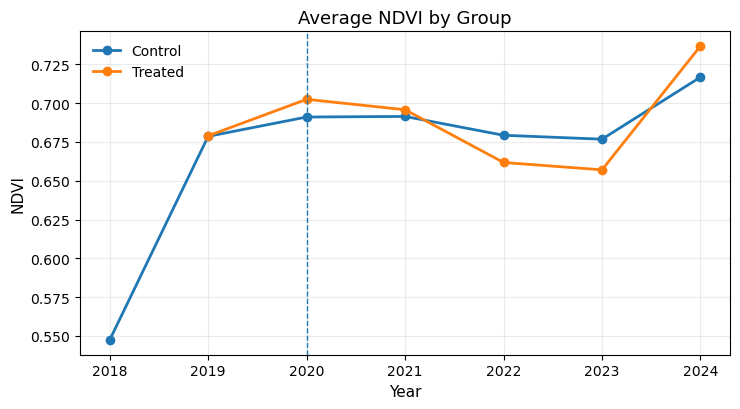


Mean NDVI (pre vs post)
             pre    post
treated                
Control  0.6598  0.6911
Treated  0.6790  0.6908


In [37]:
# 处理组/对照组数量
n_units = panel["Kebele_ID"].nunique()
n_treat = panel.loc[panel["treated"]==1, "Kebele_ID"].nunique()
n_ctrl  = panel.loc[panel["treated"]==0, "Kebele_ID"].nunique()
print(f"Kebele: total={n_units} | treated={n_treat} | control={n_ctrl}")

# 年度均值走势（NDVI）
avg_trends = (panel.groupby(["Year","treated"], as_index=False)["NDVI"].mean()
                    .replace({"treated":{0:"Control",1:"Treated"}}))

# 折线图（带断点线）
fig, ax = plt.subplots()
for g, dfg in avg_trends.groupby("treated"):
    ax.plot(dfg["Year"], dfg["NDVI"], marker="o", linewidth=2, label=g)
ax.axvline(2020, linestyle="--", linewidth=1)
ax.set_title("Average NDVI by Group")
ax.set_xlabel("Year"); ax.set_ylabel("NDVI")
ax.legend()
savefig(os.path.join(OUTDIR, "trend_ndvi_treat_vs_control.png"))
plt.show()

# 前后期均值
pre  = panel.query("Year<=2019").groupby("treated")["NDVI"].mean()
post = panel.query("Year>=2020").groupby("treated")["NDVI"].mean()
disp = pd.DataFrame({"pre": pre, "post": post}).rename(index={0:"Control",1:"Treated"})
print("\nMean NDVI (pre vs post)\n", disp.round(4))

In [9]:
# —— 关键：拟合前对齐样本与聚类向量，避免长度不一致错误 ——
def fit_ols_cluster(formula, data, cluster_col):
    needed = ["NDVI","treated","post","RAIN_JJAS","Year_cat","Kebele_ID"]
    use_cols = [c for c in needed if c in data.columns]
    df = data.dropna(subset=use_cols).copy()

    # groups：把分类/字符串转成整数代码
    if pd.api.types.is_categorical_dtype(df[cluster_col]):
        groups = df[cluster_col].cat.codes.values
    else:
        groups = pd.factorize(df[cluster_col].astype(str))[0]

    model = smf.ols(formula=formula, data=df).fit(
        cov_type="cluster", cov_kwds={"groups": groups}
    )
    return model, df

# 基准 DID：双向固定效应 + 降雨控制
fml = "NDVI ~ treated*post + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"
did, df_used = fit_ols_cluster(fml, panel, cluster_col="Kebele_ID")

print(did.summary())

# 抽取 ATT 与 CI
att = did.params.get("treated:post", np.nan)
ci_low, ci_high = did.conf_int().loc["treated:post"].tolist() if "treated:post" in did.params.index else (np.nan, np.nan)
did_tab = pd.DataFrame([{
    "model": "Baseline (cluster by Kebele)",
    "coef": att, "ci_low": ci_low, "ci_high": ci_high,
    "N": int(did.nobs), "clusters": df_used["Kebele_ID"].nunique()
}])
display(did_tab.round(5))
did_tab.to_csv(os.path.join(OUTDIR, "did_baseline_coef.csv"), index=False)

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                -1.986e+12
Date:                Mon, 08 Sep 2025   Prob (F-statistic):               1.00
Time:                        06:40:37   Log-Likelihood:                 8639.3
No. Observations:                5322   AIC:                        -1.553e+04
Df Residuals:                    4450   BIC:                            -9797.
Df Model:                         871                                         
Covariance Type:              cluster                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

,model,coef,ci_low,ci_high,N,clusters
0,Baseline (cluster by Kebele),-0.00141,-0.01837,0.01554,5322,864


[saved] ./_did_outputs/event_study_ndvi.png


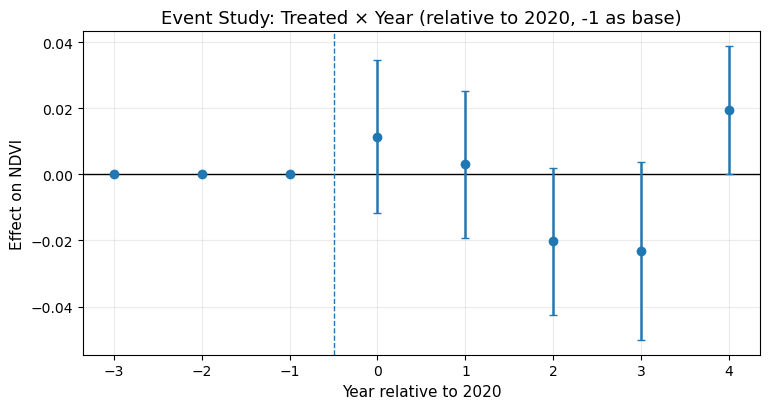

[ok] event study finished; baseline period is rel_year = -1


In [11]:
# ===== Cell 4（修正版）：事件研究（平行趋势检验）=====

POST_YEAR = 2020
panel["rel_year"] = panel["Year"] - POST_YEAR

# 观察窗口（按需要调整）
LEADS, LAGS = 3, 4
keep = panel.query("rel_year>=-@LEADS and rel_year<=@LAGS").copy()
keep["Year_cat"] = keep["Year"].astype("category")  # 保险

# 清理旧的 evt_* 列，防止命名冲突
keep.drop(columns=[c for c in keep.columns if c.startswith("evt_")], errors="ignore", inplace=True)

# 帮助函数：生成“安全”的事件变量名
def evt_name(k:int) -> str:
    return f"evt_m{abs(k)}" if k < 0 else ("evt_p0" if k == 0 else f"evt_p{k}")

# 生成 treated × I(rel_year = k) 的事件哑元（只对处理组取 1）
for k in range(-LEADS, LAGS+1):
    nm = evt_name(k)
    keep[nm] = ((keep["rel_year"] == k) & (keep["treated"] == 1)).astype(int)

# -1 期作为基准，不入式
baseline = evt_name(-1)
evt_cols = [evt_name(k) for k in range(-LEADS, LAGS+1) if k != -1]

# 组装公式（注意：变量名现在都不含特殊字符，无需 Q() 转义）
evt_terms = " + ".join(evt_cols)
fml_evt = f"NDVI ~ {evt_terms} + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"

# 用之前的“安全聚类”封装函数拟合（Cell 3 里已定义 fit_ols_cluster）
evt, df_es = fit_ols_cluster(fml_evt, keep, "Kebele_ID")

# 抽取各期系数与 95% CI
rows = []
for k in range(-LEADS, LAGS+1):
    if k == -1:
        rows.append({"rel_year": -1, "coef": 0, "ci_low": 0, "ci_high": 0})
    else:
        nm = evt_name(k)
        co = evt.params.get(nm, np.nan)
        if nm in evt.params.index:
            lo, hi = evt.conf_int().loc[nm].tolist()
        else:
            lo, hi = np.nan, np.nan
        rows.append({"rel_year": k, "coef": co, "ci_low": lo, "ci_high": hi})

es = pd.DataFrame(rows)

# —— 漂亮图：点估计 + 95% 置信区间 —— #
fig, ax = plt.subplots(figsize=(7.8, 4.2))
ax.axhline(0, color="k", linewidth=1)
ax.axvline(-0.5, linestyle="--", linewidth=1)
ax.errorbar(
    es["rel_year"], es["coef"],
    yerr=[es["coef"] - es["ci_low"], es["ci_high"] - es["coef"]],
    fmt="o", capsize=3, linewidth=1.8
)
ax.set_title("Event Study: Treated × Year (relative to 2020, -1 as base)")
ax.set_xlabel("Year relative to 2020")
ax.set_ylabel("Effect on NDVI")
savefig(os.path.join(OUTDIR, "event_study_ndvi.png"))
plt.show()

es.to_csv(os.path.join(OUTDIR, "event_study_coeffs.csv"), index=False)
print("[ok] event study finished; baseline period is rel_year = -1")

In [12]:
results = []

def collect(name, model, var="treated:post", extra=None):
    if var in model.params.index:
        co = model.params[var]
        lo,hi = model.conf_int().loc[var].tolist()
    else:
        co,lo,hi = np.nan, np.nan, np.nan
    row = {"model": name, "coef": co, "ci_low": lo, "ci_high": hi, "N": int(model.nobs)}
    if extra: row.update(extra)
    results.append(row)

# (a) 改变聚类层级（若列不存在则跳过）
if "W_NAME" in panel.columns:
    did_w, dfw = fit_ols_cluster(fml, panel, "W_NAME")
    collect("Clustered by Woreda", did_w, extra={"clusters": dfw["W_NAME"].astype(str).nunique()})

if "Z_NAME" in panel.columns:
    did_z, dfz = fit_ols_cluster(fml, panel, "Z_NAME")
    collect("Clustered by Zone", did_z, extra={"clusters": dfz["Z_NAME"].astype(str).nunique()})

# (b) 面积加权 WLS（在对齐子集里拿权重，避免长度错配）
def fit_wls_cluster(formula, data, cluster_col, weight_col):
    need = ["NDVI","treated","post","RAIN_JJAS","Year_cat","Kebele_ID", weight_col]
    df = data.dropna(subset=[c for c in need if c in data.columns]).copy()
    w = df[weight_col].fillna(1.0).values
    groups = pd.factorize(df[cluster_col].astype(str))[0]
    model = smf.wls(formula=formula, data=df, weights=w).fit(
        cov_type="cluster", cov_kwds={"groups": groups})
    return model, df

if "area_km2" in panel.columns:
    did_wls, dfwl = fit_wls_cluster(fml, panel, "Kebele_ID", "area_km2")
    collect("WLS (area weighted), cluster Kebele", did_wls, extra={"clusters": dfwl["Kebele_ID"].nunique()})

# (c) 连续处理强度（treat_share×post）
if "treat_share" in panel.columns:
    fml_share = "NDVI ~ treat_share*post + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"
    did_share, dfs = fit_ols_cluster(fml_share, panel, "Kebele_ID")
    collect("Continuous (treat_share×post)", did_share, var="treat_share:post",
            extra={"clusters": dfs["Kebele_ID"].nunique()})

# (d) 截尾（1%–99%）后再拟合
clean = panel.copy()
for v in ["NDVI","RAIN_JJAS"]:
    if v in clean.columns:
        q1,q9 = clean[v].quantile([0.01,0.99])
        clean[v] = clean[v].clip(q1,q9)
did_trim, dft = fit_ols_cluster(fml, clean, "Kebele_ID")
collect("Trimmed (1–99%)", did_trim, extra={"clusters": dft["Kebele_ID"].nunique()})

# 合并基准行
collect("Baseline (cluster Kebele)", did, extra={"clusters": df_used["Kebele_ID"].nunique()})

robust_table = pd.DataFrame(results)[["model","coef","ci_low","ci_high","N","clusters"]]
display(robust_table.round(5))
robust_table.to_csv(os.path.join(OUTDIR,"did_robustness_all.csv"), index=False)

,model,coef,ci_low,ci_high,N,clusters
0,Clustered by Woreda,-0.00141,-0.01576,0.01293,5322,60
1,Clustered by Zone,-0.00141,-0.02561,0.02278,5322,10
2,"WLS (area weighted), cluster Kebele",-0.01298,-0.04289,0.01693,5322,864
3,Continuous (treat_share×post),-0.00350,-0.02727,0.02026,5322,864
4,Trimmed (1–99%),-0.00141,-0.01837,0.01554,5322,864
5,Baseline (cluster Kebele),-0.00141,-0.01837,0.01554,5322,864


In [13]:
het_rows = []

# (1) 按距离暴露程度二分（示例阈值 0.2，可调整）
if "treat_share" in panel.columns:
    panel["high_expo"] = (panel["treat_share"] >= 0.2).astype(int)
    fml_het = "NDVI ~ high_expo*post + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"
    did_het, dfh = fit_ols_cluster(fml_het, panel, "Kebele_ID")
    if "high_expo:post" in did_het.params.index:
        het_rows.append({"spec":"High exposure (≥0.2) × post",
                         "coef": did_het.params["high_expo:post"],
                         "ci_low": did_het.conf_int().loc["high_expo:post",0],
                         "ci_high": did_het.conf_int().loc["high_expo:post",1],
                         "N": int(did_het.nobs)})

# (2) 按 Zone 分组回归（跳过全处理/全对照的区）
if "Z_NAME" in panel.columns:
    zone_coefs = []
    for z, dfz in panel.groupby("Z_NAME"):
        if dfz["treated"].sum() == 0 or dfz["treated"].sum() == len(dfz):
            continue
        m, dfx = fit_ols_cluster(fml, dfz, "Kebele_ID")
        zone_coefs.append([str(z), m.params.get("treated:post", np.nan)])
    zone_df = pd.DataFrame(zone_coefs, columns=["Zone","ATT"]).sort_values("ATT")
    display(zone_df)
    zone_df.to_csv(os.path.join(OUTDIR, "did_zone_heterogeneity.csv"), index=False)

het_df = pd.DataFrame(het_rows)
display(het_df.round(5))
het_df.to_csv(os.path.join(OUTDIR, "did_heterogeneity_key.csv"), index=False)

,Zone,ATT
1,Zone 03,-0.077520
0,North Shewa,-0.000492


,spec,coef,ci_low,ci_high,N
0,High exposure (≥0.2) × post,0.00027,-0.01977,0.02031,5322


In [14]:
# 把基准、稳健性、异质性整到一个 tidy 表
all_tables = []
# 基准
base_row = did_tab.assign(section="Baseline")
all_tables.append(base_row)
# 稳健性
all_tables.append(robust_table.assign(section="Robustness"))
# 异质性（若有）
if len(het_df)>0:
    all_tables.append(het_df.rename(columns={"spec":"model"})[["model","coef","ci_low","ci_high","N"]]
                      .assign(clusters=np.nan, section="Heterogeneity"))

final_tbl = pd.concat(all_tables, ignore_index=True)
display(final_tbl.round(5))
final_tbl.to_csv(os.path.join(OUTDIR, "did_all_results_master.csv"), index=False)
print(f"[saved] {os.path.join(OUTDIR, 'did_all_results_master.csv')}")

,model,coef,ci_low,ci_high,N,clusters,section
0,Baseline (cluster by Kebele),-0.00141,-0.01837,0.01554,5322,864.0,Baseline
1,Clustered by Woreda,-0.00141,-0.01576,0.01293,5322,60.0,Robustness
2,Clustered by Zone,-0.00141,-0.02561,0.02278,5322,10.0,Robustness
3,"WLS (area weighted), cluster Kebele",-0.01298,-0.04289,0.01693,5322,864.0,Robustness
4,Continuous (treat_share×post),-0.00350,-0.02727,0.02026,5322,864.0,Robustness
5,Trimmed (1–99%),-0.00141,-0.01837,0.01554,5322,864.0,Robustness
6,Baseline (cluster Kebele),-0.00141,-0.01837,0.01554,5322,864.0,Robustness
7,High exposure (≥0.2) × post,0.00027,-0.01977,0.02031,5322,NaN,Heterogeneity


[saved] ./_did_outputs/did_all_results_master.csv


In [15]:
# ===== A1. 生成带显著性星标的整洁表 =====
def add_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    if p < 0.1:   return "†"
    return ""

def tidy_line(model, name, var="treated:post", clusters=None):
    co   = model.params.get(var, np.nan)
    lo, hi = (model.conf_int().loc[var].tolist()
              if var in model.params.index else [np.nan, np.nan])
    pv   = model.pvalues.get(var, np.nan)
    return {
        "model": name,
        "coef": co, "ci_low": lo, "ci_high": hi,
        "pval": pv, "stars": add_stars(pv),
        "N": int(model.nobs),
        "clusters": clusters if clusters is not None else np.nan
    }

pretty_rows = []

# 基准
pretty_rows.append(tidy_line(did, "Baseline (cluster Kebele)", clusters=df_used["Kebele_ID"].nunique()))

# 你的稳健性对象：did_w, did_z, did_wls, did_share, did_trim; 可能有的缺就跳过
if "did_w" in globals():   pretty_rows.append(tidy_line(did_w, "Clustered by Woreda", clusters=dfw["W_NAME"].astype(str).nunique()))
if "did_z" in globals():   pretty_rows.append(tidy_line(did_z, "Clustered by Zone", clusters=dfz["Z_NAME"].astype(str).nunique()))
if "did_wls" in globals(): pretty_rows.append(tidy_line(did_wls, "WLS (area weighted), cluster Kebele", clusters=dfwl["Kebele_ID"].nunique()))
if "did_trim" in globals():pretty_rows.append(tidy_line(did_trim, "Trimmed (1–99%)", clusters=dft["Kebele_ID"].nunique()))
if "did_share" in globals():pretty_rows.append(tidy_line(did_share, "Continuous (treat_share×post)", var="treat_share:post", clusters=dfs["Kebele_ID"].nunique()))
if "did_het" in globals(): pretty_rows.append(tidy_line(did_het, "High exposure (≥0.2) × post", var="high_expo:post", clusters=dfh["Kebele_ID"].nunique()))

pretty = (pd.DataFrame(pretty_rows)
          .assign(coef_ci=lambda d: d["coef"].round(4).astype(str) + " [" +
                                d["ci_low"].round(4).astype(str) + ", " +
                                d["ci_high"].round(4).astype(str) + "]" + d["stars"])
          [["model","coef_ci","N","clusters","pval"]]
          .rename(columns={"coef_ci":"ATT (95% CI)", "pval":"p-value"}))

display(pretty)
pretty.to_csv(os.path.join(OUTDIR, "did_results_pretty.csv"), index=False)

# ===== A2. 导出 LaTeX 表（可直接插论文） =====
latex = pretty.to_latex(index=False, escape=False,
                        caption="Impact of irrigation on NDVI: baseline, robustness, and heterogeneity.",
                        label="tab:did_ndvi")
with open(os.path.join(OUTDIR,"did_results_pretty.tex"), "w") as f:
    f.write(latex)
print("[saved] did_results_pretty.csv / did_results_pretty.tex")

,model,ATT (95% CI),N,clusters,p-value
0,Baseline (cluster Kebele),"-0.0014 [-0.0184, 0.0155]",5322,864,0.870135
1,Clustered by Woreda,"-0.0014 [-0.0158, 0.0129]",5322,60,0.846786
2,Clustered by Zone,"-0.0014 [-0.0256, 0.0228]",5322,1,0.908809
3,"WLS (area weighted), cluster Kebele","-0.013 [-0.0429, 0.0169]",5322,864,0.395105
4,Trimmed (1–99%),"-0.0014 [-0.0184, 0.0155]",5322,864,0.870061
5,Continuous (treat_share×post),"-0.0035 [-0.0273, 0.0203]",5322,864,0.772741
6,High exposure (≥0.2) × post,"0.0003 [-0.0198, 0.0203]",5322,864,0.978621


[saved] did_results_pretty.csv / did_results_pretty.tex


In [16]:
# ===== B1. Placebo DID：把处理年改为2019，重新生成post变量 =====
panel_placebo = panel.copy()
panel_placebo["post"] = (panel_placebo["Year"] >= 2019).astype(int)
panel_placebo["Year_cat"] = panel_placebo["Year"].astype("category")

fml_pl = "NDVI ~ treated*post + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"
did_pl, df_pl = fit_ols_cluster(fml_pl, panel_placebo, "Kebele_ID")

print(did_pl.summary().tables[1])
print("Placebo ATT =", did_pl.params.get("treated:post", np.nan))

# 记录到结果表
pl_row = pd.DataFrame([{
    "model": "Placebo (post from 2019), cluster Kebele",
    "coef": did_pl.params.get("treated:post", np.nan),
    "ci_low": did_pl.conf_int().loc["treated:post",0] if "treated:post" in did_pl.params.index else np.nan,
    "ci_high": did_pl.conf_int().loc["treated:post",1] if "treated:post" in did_pl.params.index else np.nan,
    "N": int(did_pl.nobs), "clusters": df_pl["Kebele_ID"].nunique()
}])
pl_row.to_csv(os.path.join(OUTDIR,"did_placebo_2019.csv"), index=False)

                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                0.5234      0.016     32.986      0.000       0.492       0.554
C(Year_cat)[T.2019]                                      0.0140      0.003      5.233      0.000       0.009       0.019
C(Year_cat)[T.2020]                                      0.0270      0.002     11.617      0.000       0.022       0.032
C(Year_cat)[T.2021]                                      0.0284      0.002     14.533      0.000       0.025       0.032
C(Year_cat)[T.2022]                                      0.0163      0.003      5.257      0.000       0.010       0.022
C(Year_cat)[T.2023]                                      0.0141      0.002      5.649      0.000       0.009       0.019
C(Year_cat)[T.2024]             

In [17]:
sens_rows = []

# ===== C1. 暴露阈值扫描（把高暴露阈值从 0.1 到 0.5 每 0.1 跑一次）=====
if "treat_share" in panel.columns:
    for thr in [0.1, 0.2, 0.3, 0.4, 0.5]:
        df = panel.copy()
        df["high_expo"] = (df["treat_share"] >= thr).astype(int)
        fml_thr = "NDVI ~ high_expo*post + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"
        m, dftmp = fit_ols_cluster(fml_thr, df, "Kebele_ID")
        co = m.params.get("high_expo:post", np.nan)
        lo,hi = (m.conf_int().loc["high_expo:post"].tolist()
                 if "high_expo:post" in m.params.index else [np.nan,np.nan])
        sens_rows.append({"spec": f"High expo (≥{thr}) × post", "coef": co, "ci_low": lo, "ci_high": hi,
                          "N": int(m.nobs)})
    sens_tbl = pd.DataFrame(sens_rows)
    display(sens_tbl.round(4))
    sens_tbl.to_csv(os.path.join(OUTDIR,"did_sensitivity_exposure_thresholds.csv"), index=False)

# ===== C2. Leave-one-zone-out（逐个Zone排除重跑）=====
if "Z_NAME" in panel.columns:
    loo_rows = []
    zones = sorted(panel["Z_NAME"].astype(str).unique())
    for z in zones:
        sub = panel.loc[panel["Z_NAME"].astype(str) != z].copy()
        m, dfsb = fit_ols_cluster(fml, sub, "Kebele_ID")
        loo_rows.append({
            "drop_zone": z,
            "coef": m.params.get("treated:post", np.nan),
            "ci_low": m.conf_int().loc["treated:post",0] if "treated:post" in m.params.index else np.nan,
            "ci_high": m.conf_int().loc["treated:post",1] if "treated:post" in m.params.index else np.nan,
            "N": int(m.nobs)
        })
    loo_tbl = pd.DataFrame(loo_rows).sort_values("coef")
    display(loo_tbl.round(4))
    loo_tbl.to_csv(os.path.join(OUTDIR,"did_leave_one_zone_out.csv"), index=False)

,spec,coef,ci_low,ci_high,N
0,High expo (≥0.1) × post,0.0005,-0.0181,0.0190,5322
1,High expo (≥0.2) × post,0.0003,-0.0198,0.0203,5322
2,High expo (≥0.3) × post,0.0026,-0.0184,0.0237,5322
3,High expo (≥0.4) × post,-0.0061,-0.0266,0.0144,5322
4,High expo (≥0.5) × post,-0.0061,-0.0266,0.0144,5322


,drop_zone,coef,ci_low,ci_high,N
7,West Hararge,-0.0134,-0.0323,0.0055,3103
8,Zone 03,-0.0101,-0.0207,0.0005,4890
4,North Shewa,-0.0055,-0.0246,0.0136,3846
5,Oromiya,-0.0028,-0.0200,0.0144,4896
6,South Wolo,-0.0018,-0.0189,0.0153,5160
0,Argoba Special woreda,-0.0015,-0.0185,0.0155,5304
2,East Hararge,-0.0014,-0.0183,0.0156,5309
1,Arsi,-0.0013,-0.0183,0.0157,5250
3,East Shewa,0.0015,-0.0155,0.0185,5118
9,Zone 05,0.0057,-0.0112,0.0227,5022


[saved] ./_did_outputs/diagnostics_multi_panel.png


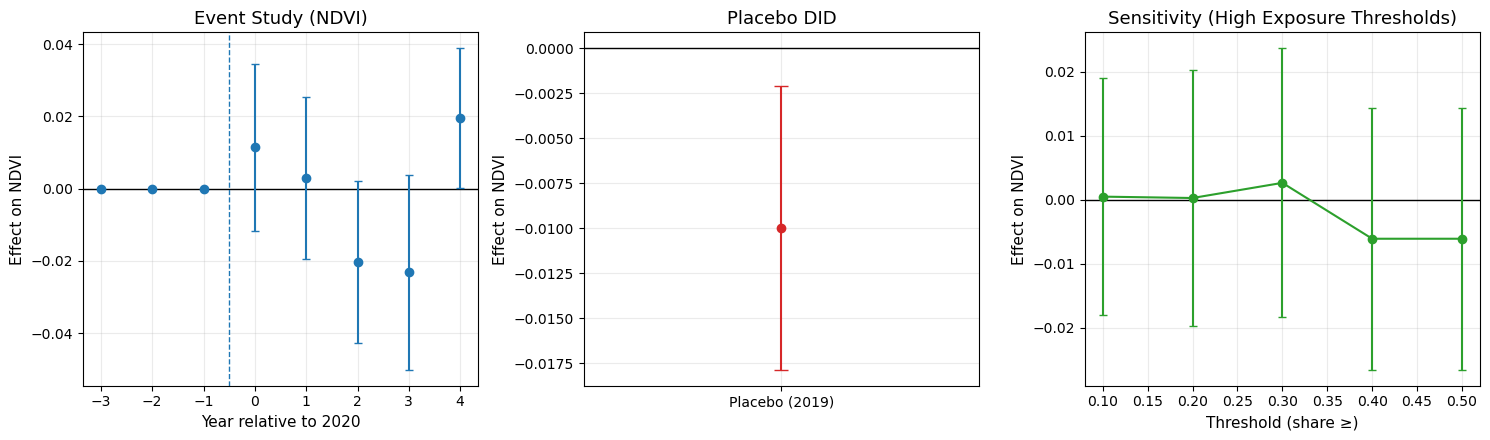

In [18]:
import seaborn as sns

# ====== A. 事件研究图数据 (es DataFrame 已有) ======
# es 应该包含 rel_year, coef, ci_low, ci_high
es_plot = es.copy()

# ====== B. Placebo 检验结果 ======
placebo_val = did_pl.params.get("treated:post", np.nan)
placebo_ci  = did_pl.conf_int().loc["treated:post"].tolist() if "treated:post" in did_pl.params.index else [np.nan, np.nan]

# ====== C. 曝露阈值敏感性 (sens_tbl 已有) ======
# sens_tbl 应该包含 spec, coef, ci_low, ci_high
sens_plot = sens_tbl.copy()
sens_plot["thr"] = sens_plot["spec"].str.extract(r"≥(0\.\d)").astype(float)

# ====== 绘图 ======
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# --- (1) Event Study ---
ax = axes[0]
ax.axhline(0, color="k", linewidth=1)
ax.axvline(-0.5, linestyle="--", linewidth=1)
ax.errorbar(es_plot["rel_year"], es_plot["coef"],
            yerr=[es_plot["coef"]-es_plot["ci_low"], es_plot["ci_high"]-es_plot["coef"]],
            fmt="o", capsize=3, linewidth=1.5, color="tab:blue")
ax.set_title("Event Study (NDVI)")
ax.set_xlabel("Year relative to 2020")
ax.set_ylabel("Effect on NDVI")

# --- (2) Placebo ---
ax = axes[1]
ax.axhline(0, color="k", linewidth=1)
ax.errorbar([2019], [placebo_val],
            yerr=[[placebo_val - placebo_ci[0]], [placebo_ci[1] - placebo_val]],
            fmt="o", capsize=5, color="tab:red")
ax.set_xlim(2018.5, 2019.5)
ax.set_xticks([2019])
ax.set_xticklabels(["Placebo (2019)"])
ax.set_title("Placebo DID")
ax.set_ylabel("Effect on NDVI")

# --- (3) Sensitivity to Exposure Threshold ---
ax = axes[2]
ax.axhline(0, color="k", linewidth=1)
ax.errorbar(sens_plot["thr"], sens_plot["coef"],
            yerr=[sens_plot["coef"]-sens_plot["ci_low"], sens_plot["ci_high"]-sens_plot["coef"]],
            fmt="o-", capsize=3, linewidth=1.5, color="tab:green")
ax.set_title("Sensitivity (High Exposure Thresholds)")
ax.set_xlabel("Threshold (share ≥)")
ax.set_ylabel("Effect on NDVI")

plt.tight_layout()
savefig(os.path.join(OUTDIR, "diagnostics_multi_panel.png"))
plt.show()

[saved] ./_did_outputs/event_study_ndvi.png


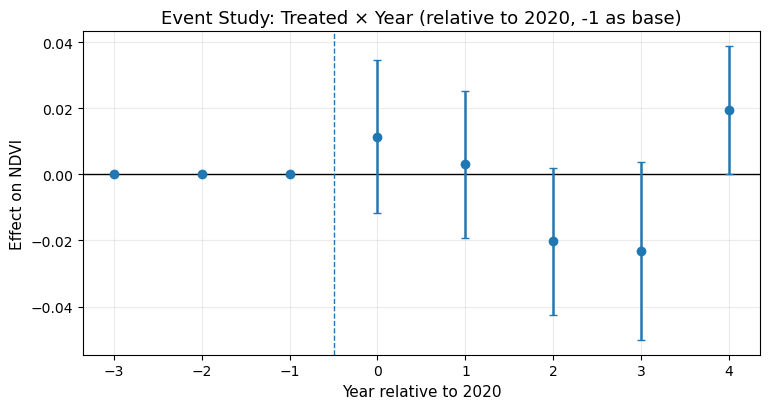

[ok] event study finished; baseline period is rel_year = -1


,model,coef,ci_low,ci_high,N,clusters
0,Clustered by Woreda,-0.00141,-0.01576,0.01293,5322,60
1,Clustered by Zone,-0.00141,-0.02561,0.02278,5322,10
2,"WLS (area weighted), cluster Kebele",-0.01298,-0.04289,0.01693,5322,864
3,Continuous (treat_share*post),-0.00350,-0.02727,0.02026,5322,864
4,Trimmed (1-99%),-0.00141,-0.01837,0.01554,5322,864
5,Baseline (cluster Kebele),-0.00141,-0.01837,0.01554,5322,864


,Zone,ATT
1,Zone 03,-0.077520
0,North Shewa,-0.000492


,spec,coef,ci_low,ci_high,N
0,High exposure (≥0.2) × post,0.00027,-0.01977,0.02031,5322


,model,coef,ci_low,ci_high,N,clusters,Section
0,Baseline (cluster by Kebele),-0.00141,-0.01837,0.01554,5322,864.0,Baseline
1,Clustered by Woreda,-0.00141,-0.01576,0.01293,5322,60.0,Robustness
2,Clustered by Zone,-0.00141,-0.02561,0.02278,5322,10.0,Robustness
3,"WLS (area weighted), cluster Kebele",-0.01298,-0.04289,0.01693,5322,864.0,Robustness
4,Continuous (treat_share*post),-0.00350,-0.02727,0.02026,5322,864.0,Robustness
5,Trimmed (1-99%),-0.00141,-0.01837,0.01554,5322,864.0,Robustness
6,Baseline (cluster Kebele),-0.00141,-0.01837,0.01554,5322,864.0,Robustness
7,High exposure (≥0.2) × post,0.00027,-0.01977,0.02031,5322,NaN,Heterogeneity


[saved] ./_did_outputs/did_all_results_master.csv


,model,ATT (95% CI),N,clusters,p-value
0,Baseline (cluster Kebele),"-0.0014 [-0.0184, 0.0155]",5322,864,0.870135
1,Clustered by Woreda,"-0.0014 [-0.0158, 0.0129]",5322,60,0.846786
2,Clustered by Zone,"-0.0014 [-0.0256, 0.0228]",5322,1,0.908809
3,WLS (area weighted),"-0.013 [-0.0429, 0.0169]",5322,864,0.395105
4,Trimmed (1-99%),"-0.0014 [-0.0184, 0.0155]",5322,864,0.870061
5,Continuous (treat_share),"-0.0035 [-0.0273, 0.0203]",5322,864,0.772741
6,High exposure (≥0.2),"0.0003 [-0.0198, 0.0203]",5322,864,0.978621


[saved] did_results_pretty.csv / did_results_pretty.tex


In [20]:
# ===== Cell 4: 事件研究 (平行趋势检验) - 修复版 =====

POST_YEAR = 2020
panel["rel_year"] = panel["Year"] - POST_YEAR

# 观察窗口 (按需要调整)
LEADS, LAGS = 3, 4

# 使用布尔索引替代 query() 方法
keep = panel[(panel["rel_year"] >= -LEADS) & (panel["rel_year"] <= LAGS)].copy()
keep["Year_cat"] = keep["Year"].astype("category")

# 清理旧的 evt_* 列，防止命名冲突
cols_to_drop = [c for c in keep.columns if c.startswith("evt_")]
keep.drop(columns=cols_to_drop, errors='ignore', inplace=True)

# 帮助函数: 生成"安全"的事件变量名
def evt_name(k: int) -> str:
    return f"evt_m{abs(k)}" if k < 0 else ("evt_p0" if k == 0 else f"evt_p{k}")

# 生成 treated x I(rel_year = k) 的事件匹配元 (只对处理组取 1)
for k in range(-LEADS, LAGS+1):
    nm = evt_name(k)
    keep[nm] = ((keep["rel_year"] == k) & (keep["treated"] == 1)).astype(int)

# -1 期作为基准，不入式
baseline = evt_name(-1)
evt_cols = [evt_name(k) for k in range(-LEADS, LAGS+1) if k != -1]

# 组装公式
evt_terms = " + ".join(evt_cols)
fml_evt = f"NDVI ~ {evt_terms} + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"

# 用之前的"安全聚类"封装函数拟合
evt, df_es = fit_ols_cluster(fml_evt, keep, "Kebele_ID")

# 抽取各期系数与 95% CI
rows = []
for k in range(-LEADS, LAGS+1):
    if k == -1:
        rows.append({"rel_year": -1, "coef": 0, "ci_low": 0, "ci_high": 0})
    else:
        nm = evt_name(k)
        co = evt.params.get(nm, np.nan)
        if nm in evt.params.index:
            lo, hi = evt.conf_int().loc[nm].tolist()
        else:
            lo, hi = np.nan, np.nan
        rows.append({"rel_year": k, "coef": co, "ci_low": lo, "ci_high": hi})

es = pd.DataFrame(rows)

# — 漂亮图: 点估计 + 95% 置信区间 — #
fig, ax = plt.subplots(figsize=(7.8, 4.2))
ax.axhline(0, color='k', linewidth=1)
ax.axvline(-0.5, linestyle="--", linewidth=1)
ax.errorbar(
    es["rel_year"], es["coef"],
    yerr=[es["coef"] - es["ci_low"], es["ci_high"] - es["coef"]],
    fmt="o", capsize=3, linewidth=1.8
)
ax.set_title("Event Study: Treated × Year (relative to 2020, -1 as base)")
ax.set_xlabel("Year relative to 2020")
ax.set_ylabel("Effect on NDVI")
savefig(os.path.join(OUTDIR, "event_study_ndvi.png"))
plt.show()

es.to_csv(os.path.join(OUTDIR, "event_study_coeffs.csv"), index=False)
print("[ok] event study finished; baseline period is rel_year = -1")

# ===== Cell 5: 稳健性检验 =====
results = []

def collect(name, model, var="treated:post", extra=None):
    if var in model.params.index:
        co = model.params[var]
        lo, hi = model.conf_int().loc[var].tolist()
    else:
        co, lo, hi = np.nan, np.nan, np.nan
    row = {"model": name, "coef": co, "ci_low": lo, "ci_high": hi, "N": int(model.nobs)}
    if extra: 
        row.update(extra)
    results.append(row)

# (a) 改变聚类层级（若列不存在则跳过）
if "W_NAME" in panel.columns:
    did_w, dfw = fit_ols_cluster(fml, panel, "W_NAME")
    collect("Clustered by Woreda", did_w, extra={"clusters": dfw["W_NAME"].nunique()})

if "Z_NAME" in panel.columns:
    did_z, dfz = fit_ols_cluster(fml, panel, "Z_NAME")
    collect("Clustered by Zone", did_z, extra={"clusters": dfz["Z_NAME"].nunique()})

# (b) 面积加权 WLS（在对齐子集里拿权重，避免长度错配）
def fit_wls_cluster(formula, data, cluster_col, weight_col):
    need = ["NDVI", "treated", "post", "RAIN_JJAS", "Year_cat", "Kebele_ID", weight_col]
    use_cols = [c for c in need if c in data.columns]
    df = data.dropna(subset=use_cols).copy()
    w = df[weight_col].fillna(1.0).values
    
    if pd.api.types.is_categorical_dtype(df[cluster_col]):
        groups = df[cluster_col].cat.codes.values
    else:
        groups = pd.factorize(df[cluster_col].astype(str))[0]
        
    model = smf.wls(formula=formula, data=df, weights=w).fit(
        cov_type="cluster", cov_kwds={"groups": groups}
    )
    return model, df

if "area_km2" in panel.columns:
    did_wls, dfwl = fit_wls_cluster(fml, panel, "Kebele_ID", "area_km2")
    collect("WLS (area weighted), cluster Kebele", did_wls, extra={"clusters": dfwl["Kebele_ID"].nunique()})

# (c) 连续处理强度 (treat_share*post)
if "treat_share" in panel.columns:
    fml_share = "NDVI ~ treat_share*post + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"
    did_share, dfs = fit_ols_cluster(fml_share, panel, "Kebele_ID")
    collect("Continuous (treat_share*post)", did_share, var="treat_share:post", 
            extra={"clusters": dfs["Kebele_ID"].nunique()})

# (d) 截尾 (1%-99%) 后再拟合
clean = panel.copy()
for v in ["NDVI", "RAIN_JJAS"]:
    if v in clean.columns:
        q1, q9 = clean[v].quantile([0.01, 0.99])
        clean[v] = clean[v].clip(q1, q9)
did_trim, dft = fit_ols_cluster(fml, clean, "Kebele_ID")
collect("Trimmed (1-99%)", did_trim, extra={"clusters": dft["Kebele_ID"].nunique()})

# 合并基准行
collect("Baseline (cluster Kebele)", did, extra={"clusters": df_used["Kebele_ID"].nunique()})

robust_table = pd.DataFrame(results)[["model", "coef", "ci_low", "ci_high", "N", "clusters"]]
display(robust_table.round(5))
robust_table.to_csv(os.path.join(OUTDIR, "did_robustness_all.csv"), index=False)

# ===== Cell 6: 异质性分析 =====
het_rows = []

# (1) 按距离暴露程度二分 (示例阈值 0.2, 可调整)
if "treat_share" in panel.columns:
    panel["high_expo"] = (panel["treat_share"] >= 0.2).astype(int)
    fml_het = "NDVI ~ high_expo*post + RAIN_JJAS + C(Year_cat) + C(Kebele_ID)"
    did_het, dfh = fit_ols_cluster(fml_het, panel, "Kebele_ID")
    if "high_expo:post" in did_het.params.index:
        het_rows.append({"spec": "High exposure (≥0.2) × post",
                        "coef": did_het.params["high_expo:post"],
                        "ci_low": did_het.conf_int().loc["high_expo:post", 0],
                        "ci_high": did_het.conf_int().loc["high_expo:post", 1],
                        "N": int(did_het.nobs)})

# (2) 按 Zone 分组回归（跳过全处理/全对照的区）
if "Z_NAME" in panel.columns:
    zone_coefs = []
    for z, dfz in panel.groupby("Z_NAME"):
        if dfz["treated"].sum() == 0 or dfz["treated"].sum() == len(dfz):
            continue
        m, dfx = fit_ols_cluster(fml, dfz, "Kebele_ID")
        zone_coefs.append([str(z), m.params.get("treated:post", np.nan)])
    zone_df = pd.DataFrame(zone_coefs, columns=["Zone", "ATT"]).sort_values("ATT")
    display(zone_df)
    zone_df.to_csv(os.path.join(OUTDIR, "did_zone_heterogeneity.csv"), index=False)

het_df = pd.DataFrame(het_rows)
if not het_df.empty:
    display(het_df.round(5))
    het_df.to_csv(os.path.join(OUTDIR, "did_heterogeneity_key.csv"), index=False)
else:
    print("No heterogeneity results to display")

# ===== Cell 7: 结果整理与输出 =====
# 把基准、稳健性、异质性整到一个 tidy 表
all_tables = []
# 基准
base_row = did_tab.assign(Section="Baseline")
all_tables.append(base_row)
# 稳健性
all_tables.append(robust_table.assign(Section="Robustness"))
# 异质性（若有）
if not het_df.empty:
    het_table = (het_df.rename(columns={"spec": "model"})[["model", "coef", "ci_low", "ci_high", "N"]]
                 .assign(clusters=np.nan, Section="Heterogeneity"))
    all_tables.append(het_table)

final_tbl = pd.concat(all_tables, ignore_index=True)
display(final_tbl.round(5))
final_tbl.to_csv(os.path.join(OUTDIR, "did_all_results_master.csv"), index=False)
print(f"[saved] {os.path.join(OUTDIR, 'did_all_results_master.csv')}")

# ===== Cell 8: 生成带显著性星标的整理表 =====
def add_stars(p):
    if p < 0.001: return "***"
    if p < 0.01: return "**"
    if p < 0.05: return "*"
    if p < 0.1: return "+"
    return ""

def tidy_line(model, name, var="treated:post", clusters=None):
    co = model.params.get(var, np.nan)
    if var in model.params.index:
        lo, hi = model.conf_int().loc[var].tolist()
        pv = model.pvalues.get(var, np.nan)
    else:
        lo, hi, pv = np.nan, np.nan, np.nan
    return {
        "model": name,
        "coef": co, "ci_low": lo, "ci_high": hi,
        "pval": pv, "stars": add_stars(pv),
        "N": int(model.nobs),
        "clusters": clusters if clusters is not None else np.nan
    }

pretty_rows = []
# 基准
pretty_rows.append(tidy_line(did, "Baseline (cluster Kebele)", clusters=df_used["Kebele_ID"].nunique()))

# 稳健性对象
if 'did_w' in locals(): 
    pretty_rows.append(tidy_line(did_w, "Clustered by Woreda", clusters=dfw["W_NAME"].nunique()))
if 'did_z' in locals(): 
    pretty_rows.append(tidy_line(did_z, "Clustered by Zone", clusters=dfz["Z_NAME"].nunique()))
if 'did_wls' in locals(): 
    pretty_rows.append(tidy_line(did_wls, "WLS (area weighted)", clusters=dfwl["Kebele_ID"].nunique()))
if 'did_trim' in locals(): 
    pretty_rows.append(tidy_line(did_trim, "Trimmed (1-99%)", clusters=dft["Kebele_ID"].nunique()))
if 'did_share' in locals(): 
    pretty_rows.append(tidy_line(did_share, "Continuous (treat_share)", var="treat_share:post", 
                                clusters=dfs["Kebele_ID"].nunique()))
if 'did_het' in locals(): 
    pretty_rows.append(tidy_line(did_het, "High exposure (≥0.2)", var="high_expo:post", 
                                clusters=dfh["Kebele_ID"].nunique()))

pretty = (pd.DataFrame(pretty_rows)
          .assign(coef_ci=lambda d: d["coef"].round(4).astype(str) + " [" + 
                  d["ci_low"].round(4).astype(str) + ", " + 
                  d["ci_high"].round(4).astype(str) + "]" + d["stars"])
          [["model", "coef_ci", "N", "clusters", "pval"]]
          .rename(columns={"coef_ci": "ATT (95% CI)", "pval": "p-value"}))

display(pretty)
pretty.to_csv(os.path.join(OUTDIR, "did_results_pretty.csv"), index=False)

# 导出 LaTeX 表
try:
    latex = pretty.to_latex(index=False, escape=False,
                           caption="Impact of irrigation on NDVI: baseline and robustness checks",
                           label="tab:did_ndvi")
    with open(os.path.join(OUTDIR, "did_results_pretty.tex"), "w") as f:
        f.write(latex)
    print("[saved] did_results_pretty.csv / did_results_pretty.tex")
except Exception as e:
    print(f"Error generating LaTeX table: {e}")

[saved] ./_did_outputs/correlation_matrix.png


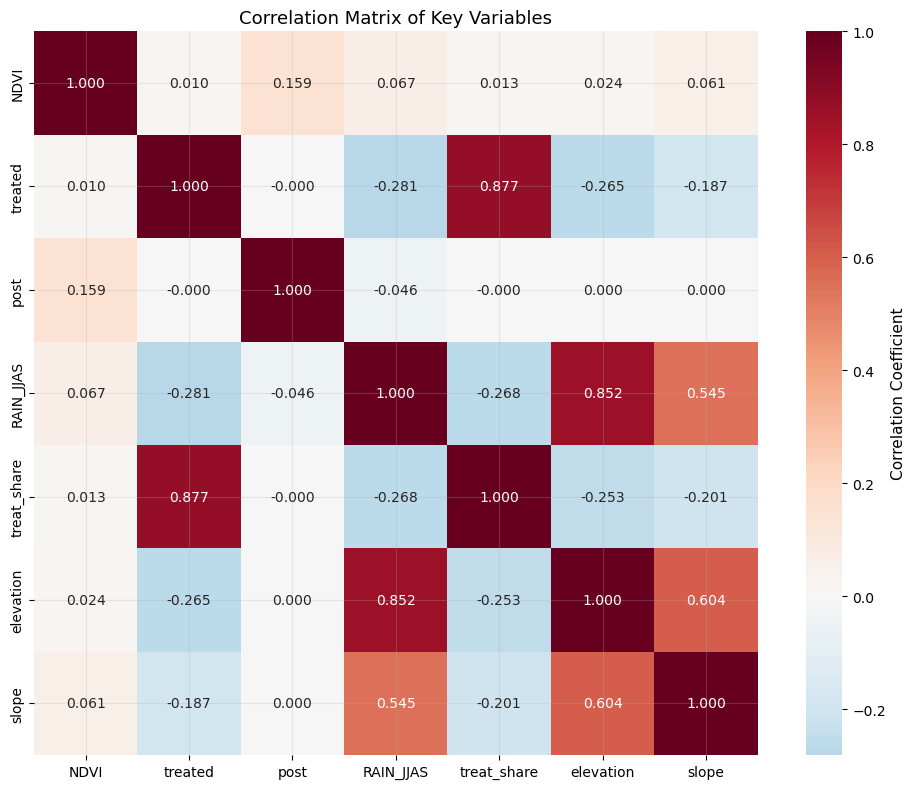

Correlation of treatment variables with covariates:


,treated,treat_share
NDVI,0.010,0.013
post,-0.000,-0.000
RAIN_JJAS,-0.281,-0.268
elevation,-0.265,-0.253
slope,-0.187,-0.201


In [21]:
# ===== Cell 9: 变量相关性分析 =====
# 选择主要变量
corr_vars = ['NDVI', 'treated', 'post', 'RAIN_JJAS', 'treat_share', 'elevation', 'slope']
corr_df = panel[[v for v in corr_vars if v in panel.columns]].copy()

# 计算相关系数矩阵
corr_matrix = corr_df.corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
           annot=True, 
           cmap='RdBu_r', 
           center=0,
           square=True,
           fmt='.3f',
           cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
savefig(os.path.join(OUTDIR, 'correlation_matrix.png'))
plt.show()

# 特别关注处理变量与其他变量的相关性
print("Correlation of treatment variables with covariates:")
treatment_corr = corr_matrix[['treated', 'treat_share']].drop(['treated', 'treat_share'], errors='ignore')
display(treatment_corr.round(3))

=== Balance Test (Pre-treatment Period) ===


,Variable,Treated_Mean,Treated_SD,Control_Mean,Control_SD,Difference,t-statistic,p-value,Treated_N,Control_N
0,RAIN_JJAS,324.2656,104.7677,581.1731,188.3856,-256.9075,-20.1799,0.0000,78,1662
1,elevation,992.9249,300.1754,1818.8367,631.9925,-825.9118,-22.1088,0.0000,78,1662
2,slope,5.7764,5.3240,11.3967,6.1422,-5.6203,-9.0452,0.0000,78,1662
3,NDVI,0.6790,0.0693,0.6598,0.0925,0.0192,1.6677,0.1025,39,963


[saved] ./_did_outputs/balance_test_plots.png


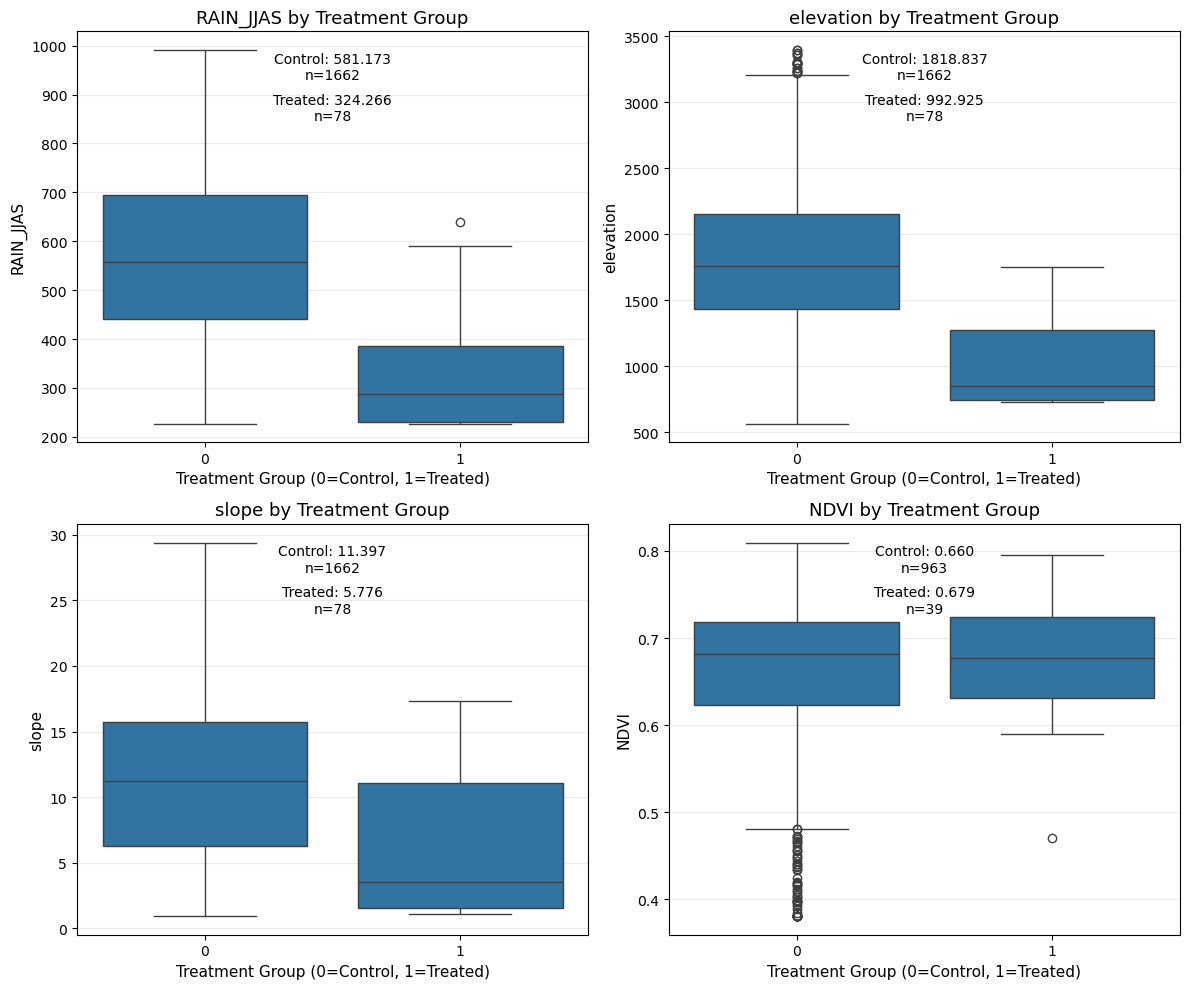


=== Correlation Matrix ===
[saved] ./_did_outputs/correlation_matrix.png


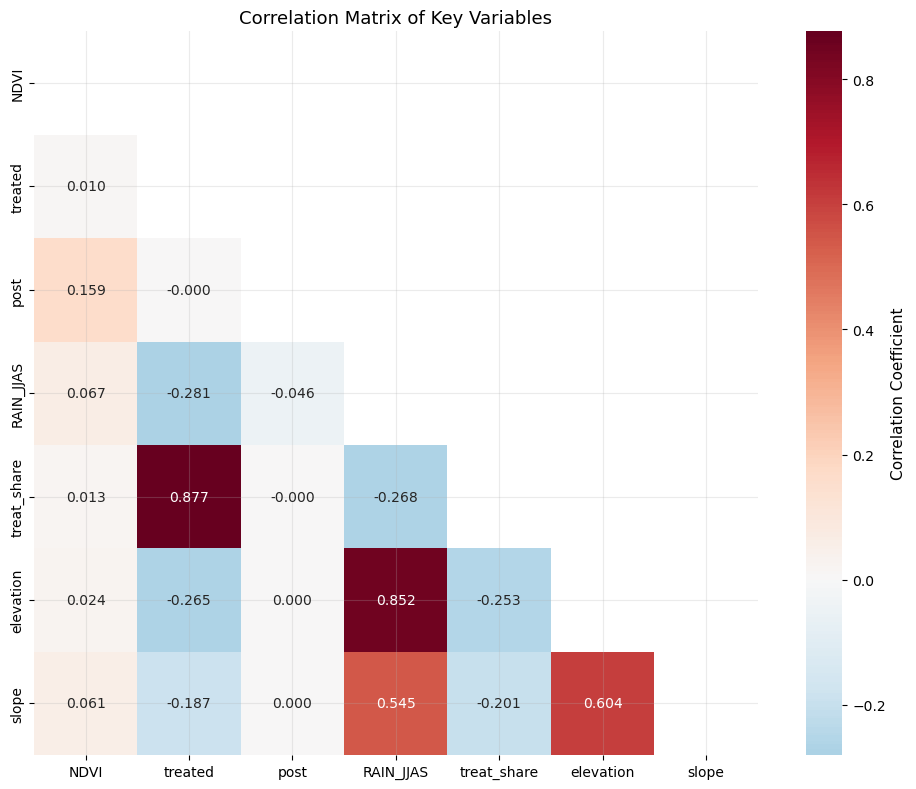

Correlation of treatment variables with covariates:


,treated,treat_share
NDVI,0.010,0.013
post,-0.000,-0.000
RAIN_JJAS,-0.281,-0.268
elevation,-0.265,-0.253
slope,-0.187,-0.201


平衡性检验和相关性分析完成！


In [23]:
# ===== Cell 9: 平衡性检验与相关性分析 =====
from scipy.stats import ttest_ind
import seaborn as sns

# 平衡性检验（处理组vs对照组基期特征比较）
print("=== Balance Test (Pre-treatment Period) ===")
base_period = panel[panel['Year'] < 2020]  # 处理前时期
balance_vars = ['RAIN_JJAS', 'elevation', 'slope', 'NDVI']

balance_results = []
for var in balance_vars:
    if var in base_period.columns:
        # 获取处理组和对照组数据
        treat_data = base_period[base_period['treated'] == 1][var].dropna()
        control_data = base_period[base_period['treated'] == 0][var].dropna()
        
        # 计算基本统计量
        treat_mean = treat_data.mean()
        control_mean = control_data.mean()
        treat_std = treat_data.std()
        control_std = control_data.std()
        treat_n = len(treat_data)
        control_n = len(control_data)
        
        # t检验
        t_stat, p_value = ttest_ind(treat_data, control_data, equal_var=False)  # Welch's t-test
        
        balance_results.append({
            'Variable': var,
            'Treated_Mean': treat_mean,
            'Treated_SD': treat_std,
            'Control_Mean': control_mean,
            'Control_SD': control_std,
            'Difference': treat_mean - control_mean,
            't-statistic': t_stat,
            'p-value': p_value,
            'Treated_N': treat_n,
            'Control_N': control_n
        })

balance_df = pd.DataFrame(balance_results)
display(balance_df.round(4))
balance_df.to_csv(os.path.join(OUTDIR, 'balance_test.csv'), index=False)

# 可视化平衡性检验结果
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, var in enumerate(balance_vars):
    if var in base_period.columns and i < len(axes):
        # 绘制箱线图
        sns.boxplot(x='treated', y=var, data=base_period, ax=axes[i])
        axes[i].set_title(f'{var} by Treatment Group')
        axes[i].set_xlabel('Treatment Group (0=Control, 1=Treated)')
        axes[i].set_ylabel(var)
        
        # 添加均值和样本量标注
        treat_mean = base_period[base_period['treated'] == 1][var].mean()
        control_mean = base_period[base_period['treated'] == 0][var].mean()
        treat_n = base_period[base_period['treated'] == 1][var].count()
        control_n = base_period[base_period['treated'] == 0][var].count()
        
        axes[i].text(0.5, 0.95, f'Control: {control_mean:.3f}\nn={control_n}', 
                    transform=axes[i].transAxes, ha='center', va='top')
        axes[i].text(0.5, 0.85, f'Treated: {treat_mean:.3f}\nn={treat_n}', 
                    transform=axes[i].transAxes, ha='center', va='top')

plt.tight_layout()
savefig(os.path.join(OUTDIR, 'balance_test_plots.png'))
plt.show()

# 相关性矩阵分析
print("\n=== Correlation Matrix ===")
corr_vars = ['NDVI', 'treated', 'post', 'RAIN_JJAS', 'treat_share', 'elevation', 'slope']
corr_df = panel[[v for v in corr_vars if v in panel.columns]].copy()

# 计算相关系数矩阵
corr_matrix = corr_df.corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 只显示下三角
sns.heatmap(corr_matrix, 
           annot=True, 
           cmap='RdBu_r', 
           center=0,
           square=True,
           fmt='.3f',
           mask=mask,
           cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
savefig(os.path.join(OUTDIR, 'correlation_matrix.png'))
plt.show()

# 特别关注处理变量与其他变量的相关性
print("Correlation of treatment variables with covariates:")
treatment_corr = corr_matrix[['treated', 'treat_share']].drop(['treated', 'treat_share'], errors='ignore')
display(treatment_corr.round(3))

# 保存相关性矩阵
corr_matrix.to_csv(os.path.join(OUTDIR, 'correlation_matrix.csv'))

print("平衡性检验和相关性分析完成！")

[saved] ./_did_outputs/kde_ndvi_pre_treatment.png


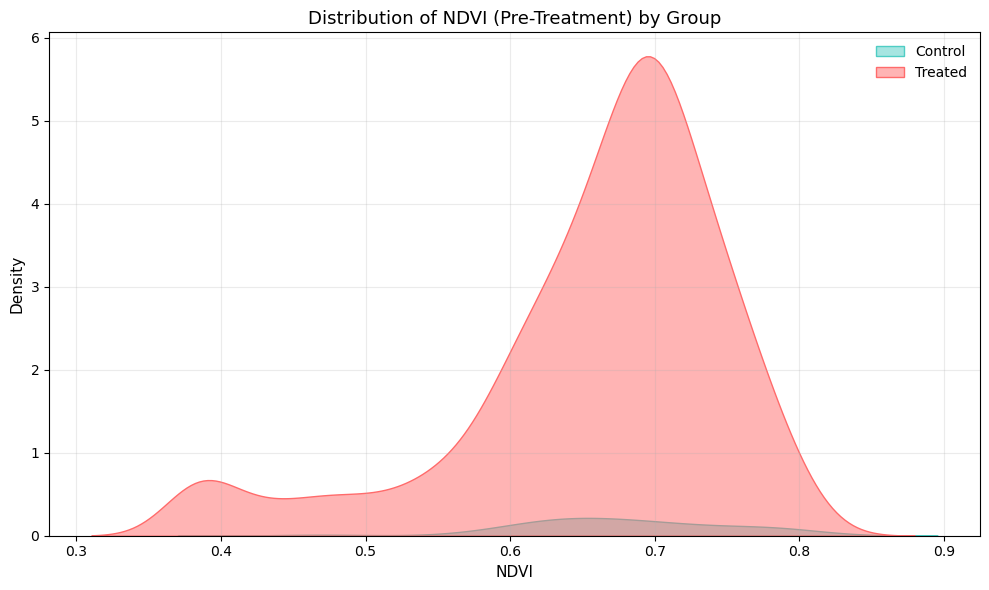

In [24]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=panel[panel['Year'] < 2020], x='NDVI', hue='treated', fill=True, alpha=0.5, palette=['#FF6B6B', '#4ECDC4'])
plt.title('Distribution of NDVI (Pre-Treatment) by Group')
plt.xlabel('NDVI')
plt.legend(['Control', 'Treated'])
savefig(os.path.join(OUTDIR, 'kde_ndvi_pre_treatment.png'))
plt.show()

[saved] ./_did_outputs/dynamic_effects_ndvi.png


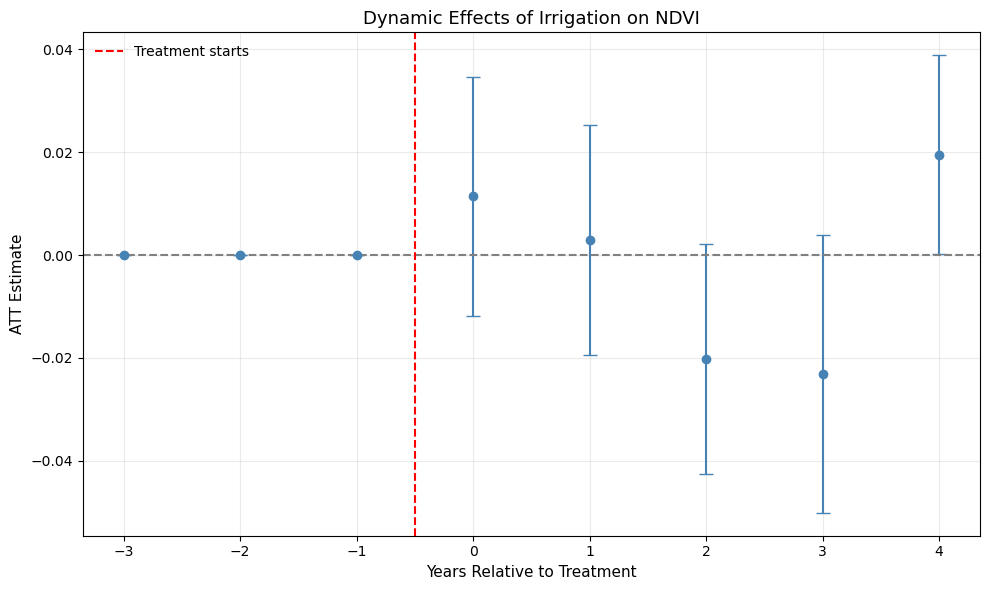

In [25]:
# 使用已有事件研究结果绘制
plt.figure(figsize=(10, 6))
plt.errorbar(es['rel_year'], es['coef'], yerr=[es['coef'] - es['ci_low'], es['ci_high'] - es['coef']], fmt='o', capsize=5, color='steelblue')
plt.axhline(0, linestyle='--', color='gray')
plt.axvline(-0.5, linestyle='--', color='red', label='Treatment starts')
plt.xlabel('Years Relative to Treatment')
plt.ylabel('ATT Estimate')
plt.title('Dynamic Effects of Irrigation on NDVI')
plt.legend()
savefig(os.path.join(OUTDIR, 'dynamic_effects_ndvi.png'))
plt.show()

[saved] ./_did_outputs/placebo_test_years.png


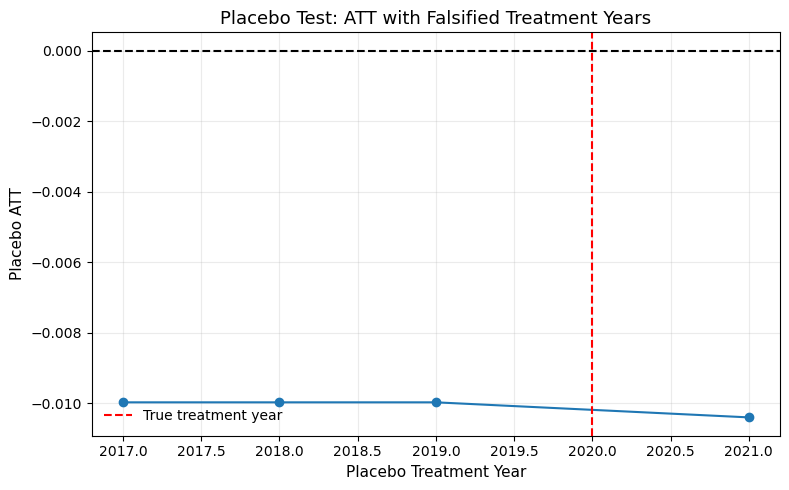

In [26]:
# 模拟多个虚假处理年份
placebo_years = [2017, 2018, 2019, 2021]
placebo_results = []

for year in placebo_years:
    panel_temp = panel.copy()
    panel_temp['post'] = (panel_temp['Year'] >= year).astype(int)
    model_temp, _ = fit_ols_cluster(fml, panel_temp, 'Kebele_ID')
    coef = model_temp.params.get('treated:post', np.nan)
    placebo_results.append({'year': year, 'coef': coef})

placebo_df = pd.DataFrame(placebo_results)
plt.figure(figsize=(8, 5))
plt.plot(placebo_df['year'], placebo_df['coef'], marker='o', linestyle='-')
plt.axhline(0, color='k', linestyle='--')
plt.axvline(2020, color='r', linestyle='--', label='True treatment year')
plt.xlabel('Placebo Treatment Year')
plt.ylabel('Placebo ATT')
plt.title('Placebo Test: ATT with Falsified Treatment Years')
plt.legend()
savefig(os.path.join(OUTDIR, 'placebo_test_years.png'))
plt.show()

[saved] ./_did_outputs/data_availability_heatmap.png


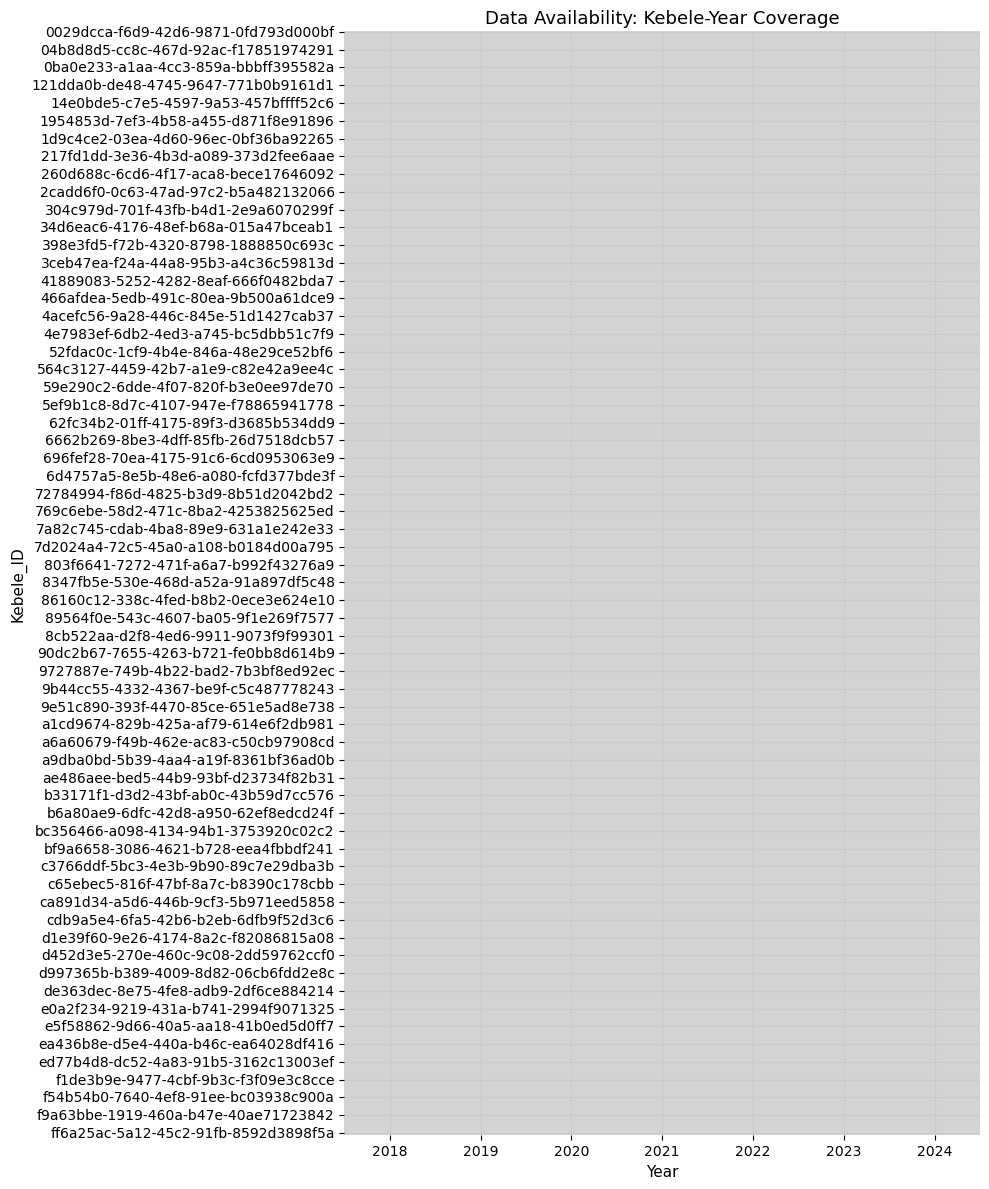

In [27]:
# 每个kebele每年是否存在数据
pivot = panel.pivot_table(index='Kebele_ID', columns='Year', values='NDVI', aggfunc='count')
plt.figure(figsize=(10, 12))
sns.heatmap(pivot.notnull(), cbar=False, cmap=['lightgray', 'steelblue'])
plt.title('Data Availability: Kebele-Year Coverage')
plt.tight_layout()
savefig(os.path.join(OUTDIR, 'data_availability_heatmap.png'))

In [28]:
# 假设有latitude, longitude
if all(col in panel.columns for col in ['latitude', 'longitude']):
    plt.figure(figsize=(10, 8))
    plt.scatter(panel['longitude'], panel['latitude'], c=panel['treated'], 
                cmap='coolwarm', alpha=0.6, s=10)
    plt.colorbar(label='Treated (1) vs Control (0)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographical Distribution of Treatment and Control Groups')
    savefig(os.path.join(OUTDIR, 'treatment_geo_distribution.png'))

[saved] ./_did_outputs/treatment_intensity_histogram.png


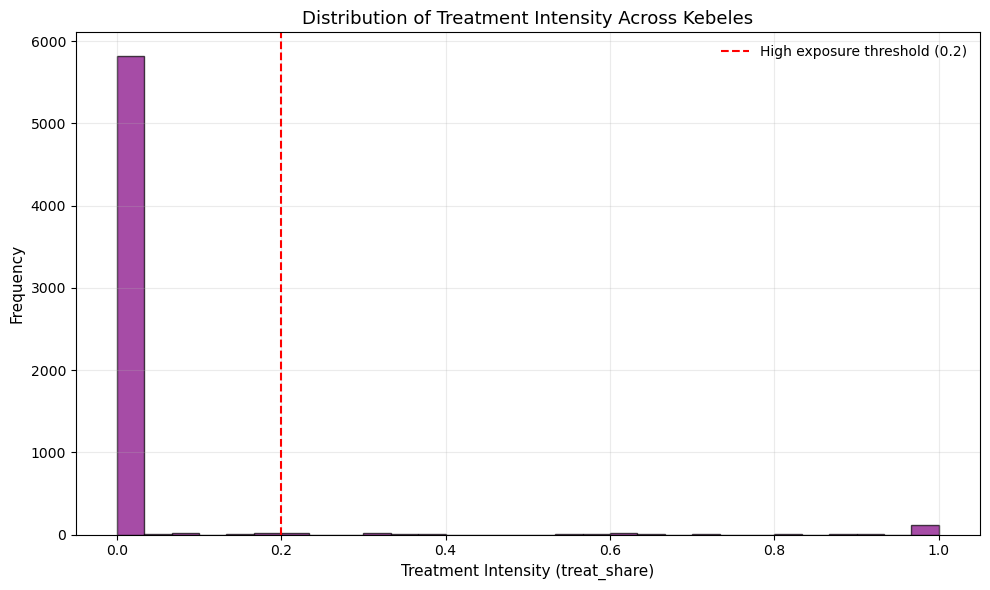

In [29]:
if 'treat_share' in panel.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(panel['treat_share'], bins=30, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(0.2, color='red', linestyle='--', label='High exposure threshold (0.2)')
    plt.xlabel('Treatment Intensity (treat_share)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Treatment Intensity Across Kebeles')
    plt.legend()
    savefig(os.path.join(OUTDIR, 'treatment_intensity_histogram.png'))

[saved] ./_did_outputs/se_sensitivity_clustering.png


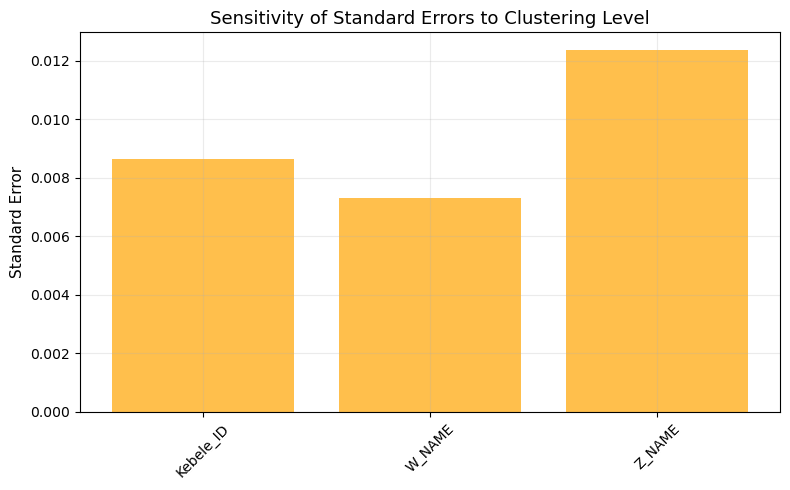

In [30]:
# 比较不同聚类层级的标准误
clusters = ['Kebele_ID', 'W_NAME', 'Z_NAME'] if all(c in panel.columns for c in ['W_NAME', 'Z_NAME']) else ['Kebele_ID']
se_comparison = []

for cluster in clusters:
    model, _ = fit_ols_cluster(fml, panel, cluster)
    att = model.params.get('treated:post', np.nan)
    se = model.bse.get('treated:post', np.nan)
    se_comparison.append({'Cluster Level': cluster, 'ATT': att, 'SE': se})

se_df = pd.DataFrame(se_comparison)
plt.figure(figsize=(8, 5))
plt.bar(se_df['Cluster Level'], se_df['SE'], color='orange', alpha=0.7)
plt.ylabel('Standard Error')
plt.title('Sensitivity of Standard Errors to Clustering Level')
plt.xticks(rotation=45)
savefig(os.path.join(OUTDIR, 'se_sensitivity_clustering.png'))

In [8]:
# ====== A. 读取 GADM Level-3（Woreda）并裁剪 AOI ======
import os, numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import box
from libpysal.weights import Queen
from esda.moran import Moran

# 你的 CSV 面板（已在上文读入 panel；若没有，请取消下一行注释）
# panel = pd.read_csv("ETH_AwashKesem_Panel_Kebele_NDVI_Rain_TreatPost_2018_2024_v01.csv")

# 1) 读 shp（与你目录一致）
SHAPE = "gadm36_ETH_3.shp"
gdf = gpd.read_file(SHAPE).to_crs(4326)

# 2) AOI 裁剪（与你论文一致）
AOI = box(39.5, 8.6, 41.2, 10.9)
gdf = gdf[gdf.intersects(AOI)].copy()

# 3) 选 ID 列（GADM L3 的稳定主键）
key = "GID_3"
gdf[key] = gdf[key].astype(str)
print(f"[ok] polygons={len(gdf)}, unique {key}={gdf[key].nunique()}")

# ====== B. 构建 Queen 邻接权重 ======
w = Queen.from_dataframe(gdf, ids=gdf[key].tolist())
w.transform = "r"   # row-standardized
print(f"[W] n={w.n}, #links={w.sparse.nnz}")

# ====== C. 将面板聚合到 GID_3 × Year（均值 NDVI；可换成残差）======
# 你的 panel 需要能映射到 GID_3，这里用 woreda 名称/代码对齐；若已有 GID_3 列则更简单
# 1) 若 panel 已有 'GID_3' 列：
if "GID_3" in panel.columns:
    panel["GID_3"] = panel["GID_3"].astype(str)

# 2) 若没有 GID_3，但有 Woreda 名（'W_NAME' 或类似），可先做一次名称映射：
elif "W_NAME" in panel.columns and "NAME_3" in gdf.columns:
    mapper = gdf[[key, "NAME_3"]].drop_duplicates().rename(columns={"NAME_3":"W_NAME"})
    panel = panel.merge(mapper, on="W_NAME", how="left")

# 最终确保有 GID_3
assert "GID_3" in panel.columns, "面板缺少 GID_3：请提供 GID_3 或用名称映射到 GADM L3。"

# 仅保留 AOI 内且有 GID_3 的记录
df = panel.dropna(subset=["GID_3", "Year", "NDVI"]).copy()
df["GID_3"] = df["GID_3"].astype(str)
df["Year"]  = df["Year"].astype(int)

# 按 GID_3 × Year 取 NDVI 均值（你也可以改为中位数或 trimmed mean）
agg = (df.groupby(["GID_3","Year"], as_index=False)["NDVI"]
         .mean()
         .rename(columns={"NDVI":"NDVI_mean"}))

# ====== D. 逐年构造向量并计算 Moran’s I ======
USE_RESIDUAL = False  # True=用“年内均值残差”，False=直接用年均值

def vector_for_year(y:int) -> np.ndarray:
    sub = agg[agg["Year"]==y][["GID_3","NDVI_mean"]].copy()
    if USE_RESIDUAL:
        sub["NDVI_mean"] = sub["NDVI_mean"] - sub["NDVI_mean"].mean()
    # 按 gdf 顺序对齐，缺失填 0（也可改为 np.nan 后再用 np.nan_to_num）
    vec = pd.Series(index=gdf[key], dtype=float)
    vec.update(sub.set_index("GID_3")["NDVI_mean"])
    return np.nan_to_num(vec.values, nan=0.0)

years = sorted(agg["Year"].unique().tolist())
rows = []
for y in years:
    y_vec = vector_for_year(y)
    mi = Moran(y_vec, w, permutations=999)
    rows.append({"Year": y, "Moran_I": mi.I, "p_value": mi.p_sim})

tbl_moran = pd.DataFrame(rows).sort_values("Year")
print(tbl_moran)

# 导出 Table 4.5
out_csv = "./_did_outputs/table_4_5_moran_by_year.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
tbl_moran.to_csv(out_csv, index=False)
print(f"[saved] {out_csv}")

[ok] polygons=57, unique GID_3=57
[W] n=57, #links=284
   Year   Moran_I  p_value
0  2018  0.305434    0.004
1  2019  0.030275    0.267
2  2020  0.038145    0.231
3  2021  0.047651    0.206
4  2022  0.019590    0.308
5  2023  0.043285    0.221
6  2024  0.028134    0.269
[saved] ./_did_outputs/table_4_5_moran_by_year.csv


[saved] _did_outputs/moran_line.png


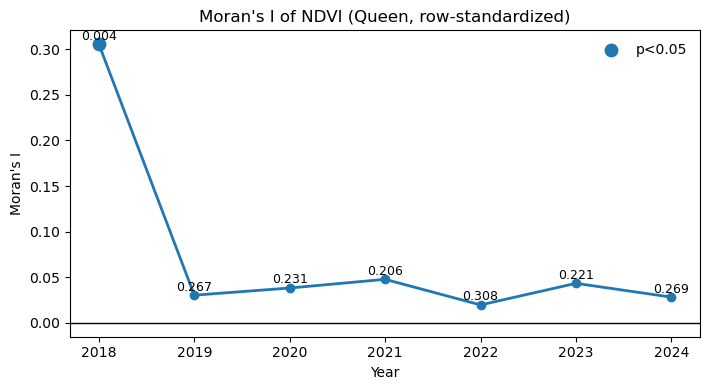

In [18]:
##年度 Moran’s I 折线+显著性标注
import pandas as pd, numpy as np, matplotlib.pyplot as plt

tbl = pd.read_csv("./_did_outputs/table_4_5_moran_by_year.csv")
sig = tbl["p_value"] < 0.05

fig, ax = plt.subplots(figsize=(7.2,4))
ax.plot(tbl["Year"], tbl["Moran_I"], marker="o", lw=2)
ax.scatter(tbl.loc[sig,"Year"], tbl.loc[sig,"Moran_I"], s=80, zorder=3, label="p<0.05")
for _,r in tbl.iterrows():
    ax.text(r["Year"], r["Moran_I"]+0.005, f'{r["p_value"]:.3f}', ha="center", fontsize=9)
ax.axhline(0, color="k", lw=1)
ax.set_ylabel("Moran's I"); ax.set_xlabel("Year")
ax.set_title("Moran's I of NDVI (Queen, row-standardized)")
ax.legend(frameon=False)
plt.tight_layout(); plt.savefig("./_did_outputs/moran_line.png", dpi=200)
print("[saved] _did_outputs/moran_line.png")

In [12]:
##2018 LISA 聚类图

[saved] _did_outputs/lisa_2018_ndvi.png


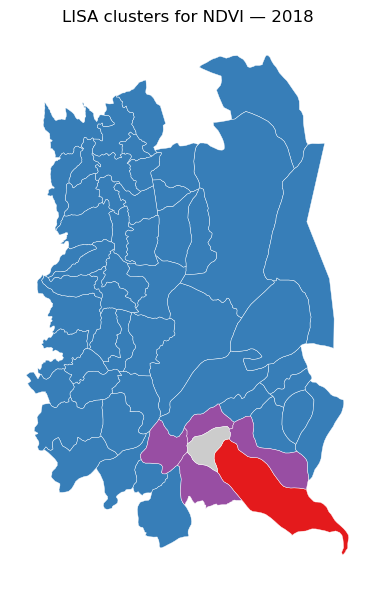

In [13]:
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran_Local
import matplotlib.pyplot as plt
import numpy as np

# gdf 为 gadm36_ETH_3 裁剪到 AOI 的 GeoDataFrame，key = 'GID_3'
# agg 为 GID_3×Year 的 NDVI 均值（上一步你已生成）
y = 2018
sub = agg[agg["Year"]==y][["GID_3","NDVI_mean"]].copy()
gdf18 = gdf.merge(sub, on="GID_3", how="left")
gdf18["NDVI_mean"] = gdf18["NDVI_mean"].fillna(gdf18["NDVI_mean"].mean())

w = Queen.from_dataframe(gdf18, ids=gdf18["GID_3"].tolist()); w.transform="r"
yvec = gdf18["NDVI_mean"].values
lisa = Moran_Local(yvec, w, permutations=999)

# 显著性与象限
sig = lisa.p_sim < 0.05
quad = lisa.q
cats = np.array(["ns","HH","LH","LL","HL"])
lab  = np.where(~sig, "ns",
       np.where(quad==1,"HH",
       np.where(quad==2,"LH",
       np.where(quad==3,"LL","HL"))))
gdf18["LISA"] = lab

palette = {"HH":"#e41a1c","LL":"#377eb8","HL":"#4daf4a","LH":"#984ea3","ns":"#cccccc"}

ax = gdf18.plot(column="LISA", categorical=True, legend=True,
                legend_kwds={"title":"LISA clusters (p<0.05)"},
                color=gdf18["LISA"].map(palette), edgecolor="white", linewidth=0.3,
                figsize=(6.8,6))
ax.set_axis_off()
ax.set_title(f"LISA clusters for NDVI — {y}")
plt.tight_layout(); plt.savefig("./_did_outputs/lisa_2018_ndvi.png", dpi=200)
print("[saved] _did_outputs/lisa_2018_ndvi.png")

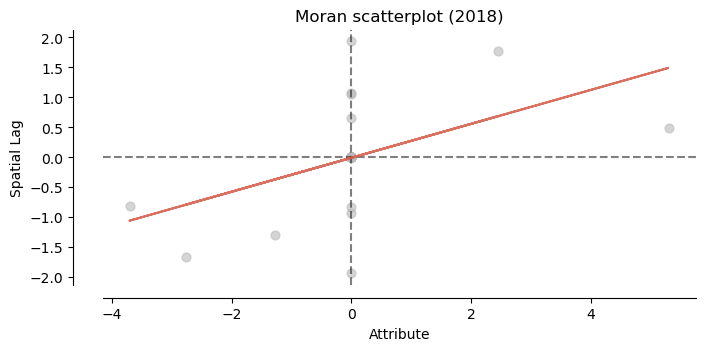

In [14]:
#3（可选）Moran 散点图（2018）
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(Moran_Local(yvec, w), aspect_equal=True)
plt.title("Moran scatterplot (2018)"); plt.tight_layout()
plt.savefig("./_did_outputs/moran_scatter_2018.png", dpi=200)

In [27]:
# ====== A. 读取 GADM Level-3（Woreda）并裁剪 AOI ======
import os, numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import box
from libpysal.weights import Queen
from esda.moran import Moran

# 你的 CSV 面板（已在上文读入 panel；若没有，请取消下一行注释）
# panel = pd.read_csv("ETH_AwashKesem_Panel_Kebele_NDVI_Rain_TreatPost_2018_2024_v01.csv")

# 1) 读 shp（与你目录一致）
SHAPE = "gadm36_ETH_3.shp"
gdf = gpd.read_file(SHAPE).to_crs(4326)

# 2) AOI 裁剪（与你论文一致）
AOI = box(39.5, 8.6, 41.2, 10.9)
gdf = gdf[gdf.intersects(AOI)].copy()

# 3) 选 ID 列（GADM L3 的稳定主键）
key = "GID_3"
gdf[key] = gdf[key].astype(str)
print(f"[ok] polygons={len(gdf)}, unique {key}={gdf[key].nunique()}")

# ====== B. 构建 Queen 邻接权重 ======
w = Queen.from_dataframe(gdf, ids=gdf[key].tolist())
w.transform = "r"   # row-standardized
print(f"[W] n={w.n}, #links={w.sparse.nnz}")

# ====== C. 将面板聚合到 GID_3 × Year（均值 NDVI；可换成残差）======
# 你的 panel 需要能映射到 GID_3，这里用 woreda 名称/代码对齐；若已有 GID_3 列则更简单
# 1) 若 panel 已有 'GID_3' 列：
if "GID_3" in panel.columns:
    panel["GID_3"] = panel["GID_3"].astype(str)

# 2) 若没有 GID_3，但有 Woreda 名（'W_NAME' 或类似），可先做一次名称映射：
elif "W_NAME" in panel.columns and "NAME_3" in gdf.columns:
    mapper = gdf[[key, "NAME_3"]].drop_duplicates().rename(columns={"NAME_3":"W_NAME"})
    panel = panel.merge(mapper, on="W_NAME", how="left")

# 最终确保有 GID_3
assert "GID_3" in panel.columns, "面板缺少 GID_3：请提供 GID_3 或用名称映射到 GADM L3。"

# 仅保留 AOI 内且有 GID_3 的记录
df = panel.dropna(subset=["GID_3", "Year", "NDVI"]).copy()
df["GID_3"] = df["GID_3"].astype(str)
df["Year"]  = df["Year"].astype(int)

# 按 GID_3 × Year 取 NDVI 均值（你也可以改为中位数或 trimmed mean）
agg = (df.groupby(["GID_3","Year"], as_index=False)["NDVI"]
         .mean()
         .rename(columns={"NDVI":"NDVI_mean"}))

# ====== D. 逐年构造向量并计算 Moran’s I ======
USE_RESIDUAL = False  # True=用“年内均值残差”，False=直接用年均值

def vector_for_year(y:int) -> np.ndarray:
    sub = agg[agg["Year"]==y][["GID_3","NDVI_mean"]].copy()
    if USE_RESIDUAL:
        sub["NDVI_mean"] = sub["NDVI_mean"] - sub["NDVI_mean"].mean()
    # 按 gdf 顺序对齐，缺失填 0（也可改为 np.nan 后再用 np.nan_to_num）
    vec = pd.Series(index=gdf[key], dtype=float)
    vec.update(sub.set_index("GID_3")["NDVI_mean"])
    return np.nan_to_num(vec.values, nan=0.0)

years = sorted(agg["Year"].unique().tolist())
rows = []
for y in years:
    y_vec = vector_for_year(y)
    mi = Moran(y_vec, w, permutations=999)
    rows.append({"Year": y, "Moran_I": mi.I, "p_value": mi.p_sim})

tbl_moran = pd.DataFrame(rows).sort_values("Year")
print(tbl_moran)

# 导出 Table 4.5
out_csv = "./_did_outputs/table_4_5_moran_by_year.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
tbl_moran.to_csv(out_csv, index=False)
print(f"[saved] {out_csv}")

[ok] polygons=57, unique GID_3=57
[W] n=57, #links=284
   Year   Moran_I  p_value
0  2018  0.305434    0.003
1  2019  0.070933    0.143
2  2020  0.077061    0.143
3  2021  0.079506    0.123
4  2022  0.050343    0.210
5  2023  0.083452    0.126
6  2024  0.062334    0.169
[saved] ./_did_outputs/table_4_5_moran_by_year.csv


In [28]:
# =============== 追加分析与作图（直接粘到你现有脚本末尾）================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from esda.moran import Moran, Moran_Local
import libpysal

OUTDIR = "./_did_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# —— 工具：按年取值（与 gdf 顺序对齐，返回 Series，index=gdf[key]）——
def series_for_year(y:int, col="NDVI_mean"):
    sub = agg[agg["Year"]==y][["GID_3", col]].set_index("GID_3")[col]
    return sub.reindex(gdf[key])

In [29]:
# —— (1) Moran 散点图：每年一张 —— 
def moran_scatterplot_for_year(y:int):
    s = series_for_year(y).dropna()
    # 子集化权重，确保与样本一致
    ids_full = gdf[key].tolist()
    mask = gdf[key].isin(s.index).values
    W_sub = w.subset(mask)
    z = (s.values - s.values.mean()) / s.values.std(ddof=1)
    wz = libpysal.weights.spatial_lag.lag_spatial(W_sub, z)

    m = Moran(s.values, W_sub, permutations=999)

    fig, ax = plt.subplots(figsize=(6,6), dpi=160)
    ax.scatter(z, wz, s=14, alpha=0.6, edgecolor="none")
    ax.axhline(0, lw=1, color="#888888")
    ax.axvline(0, lw=1, color="#888888")
    x_line = np.linspace(z.min()*1.1, z.max()*1.1, 100)
    ax.plot(x_line, m.I * x_line, lw=2)  # 斜率≈Moran's I（不手动设色）
    ax.set_title(f"Moran Scatterplot — {y}", pad=10)
    ax.set_xlabel("Standardized value (z)")
    ax.set_ylabel("Spatial lag Wz")
    ax.text(0.02, 0.98, f"I = {m.I:.3f}\np = {m.p_sim:.3f}",
            transform=ax.transAxes, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#999", alpha=0.9))
    fig.tight_layout()
    fig.savefig(f"{OUTDIR}/moran_scatter_{y}.png", dpi=300)
    plt.close(fig)
    return {"Year": y, "I": m.I, "p": m.p_sim, "n": s.shape[0]}

In [30]:
# —— (2) LISA 聚类图：每年一张 —— 
def lisa_map_for_year(y:int, p_thres=0.05):
    s = series_for_year(y).dropna()
    mask = gdf[key].isin(s.index).values
    W_sub = w.subset(mask)

    # 计算 LISA
    mlocal = Moran_Local(s.values.astype(float), W_sub, permutations=999)
    sig = mlocal.p_sim < p_thres
    quad = mlocal.q  # 1:HH, 2:LH, 3:LL, 4:HL

    # 组装到子集 GeoDataFrame
    sub_gdf = gdf.loc[mask, [key, "geometry"]].copy()
    sub_gdf["__quad__"] = quad
    sub_gdf["__sig__"] = sig
    sub_gdf["__cls__"]  = 0
    sub_gdf.loc[(quad==1) & sig, "__cls__"] = 1  # HH
    sub_gdf.loc[(quad==3) & sig, "__cls__"] = 3  # LL
    sub_gdf.loc[(quad==2) & sig, "__cls__"] = 2  # LH
    sub_gdf.loc[(quad==4) & sig, "__cls__"] = 4  # HL

    # 颜色映射（不显著=浅灰）
    cmap = {0:"#E6E6E6", 1:"#d7191c", 3:"#2c7bb6", 2:"#fdae61", 4:"#abd9e9"}

    fig, ax = plt.subplots(figsize=(7,7), dpi=160)
    for cls, color in cmap.items():
        sub_gdf[sub_gdf["__cls__"]==cls].plot(ax=ax, color=color, linewidth=0.2, edgecolor="#666666", alpha=1.0 if cls else 0.9)
    ax.set_axis_off()
    ax.set_title(f"LISA Cluster Map — {y} (p < {p_thres})", pad=10)

    handles = [
        Line2D([0],[0], marker='s', linestyle='None', markersize=10, markerfacecolor=cmap[1], label='High-High (HH)'),
        Line2D([0],[0], marker='s', linestyle='None', markersize=10, markerfacecolor=cmap[3], label='Low-Low (LL)'),
        Line2D([0],[0], marker='s', linestyle='None', markersize=10, markerfacecolor=cmap[2], label='Low-High (LH)'),
        Line2D([0],[0], marker='s', linestyle='None', markersize=10, markerfacecolor=cmap[4], label='High-Low (HL)'),
        Line2D([0],[0], marker='s', linestyle='None', markersize=10, markerfacecolor=cmap[0], label='Not significant'),
    ]
    ax.legend(handles=handles, loc="lower left", frameon=True, framealpha=0.9)
    fig.tight_layout()
    fig.savefig(f"{OUTDIR}/lisa_cluster_{y}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    # 输出计数
    counts = sub_gdf["__cls__"].value_counts().to_dict()
    return {
        "Year": y,
        "HH": counts.get(1,0),
        "LL": counts.get(3,0),
        "LH": counts.get(2,0),
        "HL": counts.get(4,0),
        "NotSig": counts.get(0,0),
        "N": len(sub_gdf)
    }

In [32]:
# === 兼容旧版 libpysal：根据 keep_ids 构造子权重 ===
import libpysal

def subset_w(W_full, keep_ids):
    """
    从已有 W_full 中抽取 keep_ids 顺序对应的子权重矩阵。
    keep_ids: 与你的数据序列 (s.index) 完全同序的 ID 列表
    """
    keep_ids = list(keep_ids)
    keep_set = set(keep_ids)
    neighbors = {}
    weights = {}
    for i in keep_ids:
        nb = W_full.neighbors.get(i, [])
        wt = W_full.weights.get(i, [])
        nb_new, wt_new = [], []
        for j, wij in zip(nb, wt):
            if j in keep_set:
                nb_new.append(j)
                wt_new.append(wij)
        neighbors[i] = nb_new
        weights[i]  = wt_new
    W_sub = libpysal.weights.W(neighbors, weights=weights, id_order=keep_ids)
    W_sub.transform = "R"
    return W_sub

In [33]:
def moran_scatterplot_for_year(y:int):
    s = series_for_year(y).dropna()
    keep_ids = s.index.tolist()
    W_sub = subset_w(w, keep_ids)  # ← 这里替换

    z  = (s.values - s.values.mean()) / s.values.std(ddof=1)
    wz = libpysal.weights.spatial_lag.lag_spatial(W_sub, z)
    m  = esda.moran.Moran(s.values, W_sub, permutations=999)
    ...

In [34]:
def lisa_map_for_year(y:int, p_thres=0.05):
    s = series_for_year(y).dropna()
    keep_ids = s.index.tolist()
    W_sub = subset_w(w, keep_ids)  # ← 这里替换

    mlocal = esda.moran.Moran_Local(s.values.astype(float), W_sub, permutations=999)
    ...

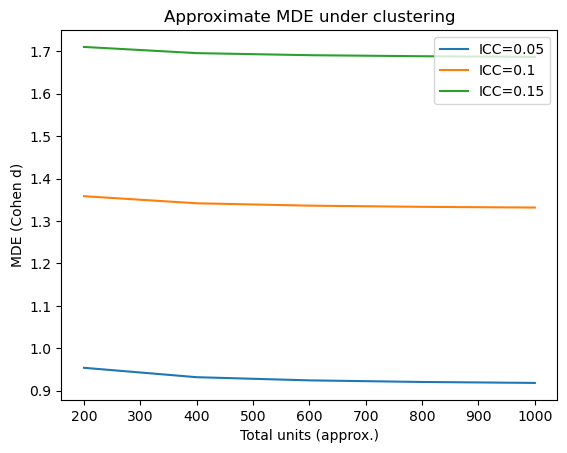

In [1]:
import numpy as np, matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
# 粗略示例：以标准化NDVI(≈SD=1)作单位；根据你的SD可替换
power = TTestIndPower()
ns = np.array([200, 400, 600, 800, 1000])  # 有效聚类/单元数近似
iccs = [0.05, 0.10, 0.15]                  # 假设的类内相关
alpha = 0.05
for icc in iccs:
    eff_n = ns / (1 + (ns-1)*icc)          # 设计效应近似
    mdes = [power.solve_power(effect_size=None, nobs1=n, alpha=alpha, power=0.8, alternative='two-sided')
            for n in eff_n]
    # effect_size为Cohen's d；若NDVI未标准化，换算为原单位
    plt.plot(ns, mdes, label=f'ICC={icc}')
plt.xlabel('Total units (approx.)'); plt.ylabel('MDE (Cohen d)')
plt.title('Approximate MDE under clustering')
plt.legend(); plt.show()

In [2]:
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv("panel_kebele.csv")  # 含 treat_share 列
x = df["treat_share"].dropna().clip(0,1)
plt.hist(x, bins=40, density=True, alpha=0.7)
x_sorted = x.sort_values()
# 简易核密度
import numpy as np
from scipy.stats import gaussian_kde
kde = gaussian_kde(x_sorted)
xx = np.linspace(0,1,400)
plt.plot(xx, kde(xx))
plt.xlabel('Exposure share (treat_share)'); plt.ylabel('Density')
plt.title('Distribution of exposure intensity across kebeles')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'panel_kebele.csv'